In [9]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

# hack to import files from parent directory
import os
import sys
upper_dir = os.path.abspath(os.path.join('..'))
if upper_dir not in sys.path:
    sys.path.append(upper_dir)
    

# packages existing in parent directory
from LeNet.lenet import LeNet5
import hercules.ntk_utils as ntk_utils



In [10]:
# Create and save 'num_runs' randomly initialized parameters
num_runs = 10
checkpoint_dir = '../checkpoints/run1'

for i in range(num_runs):
    net = LeNet5(c=3)
    print('saving model checkpoint')
    torch.save(net, '{}/init{}.p'.format(checkpoint_dir, i))

saving model checkpoint
saving model checkpoint
saving model checkpoint
saving model checkpoint
saving model checkpoint
saving model checkpoint
saving model checkpoint
saving model checkpoint
saving model checkpoint
saving model checkpoint


In [11]:
# Import the MNIST dataset and prepare dataloader
batch_size= 5000

data_train = datasets.CIFAR10('../data/cifar',
                  train=True,
                  download=True,
                  transform=transforms.Compose([
                      transforms.Resize((32, 32)),
                      transforms.ToTensor()]))

per_grad_train_loader = DataLoader(data_train, batch_size=batch_size, shuffle=True, num_workers=2)
slow_loader = DataLoader(data_train, batch_size=1, shuffle=False)

Files already downloaded and verified


In [12]:
import torch.nn as nn

class Linear(nn.Module):
    def __init__(self, dim, c):
        super(Linear, self).__init__()
        self.layer = nn.Linear(dim, c)

    def forward(self, x):
        return self.layer(x)

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm

linear = Linear(3*32*32, 10)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(linear.parameters(), lr=0.01,
                      momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
device="cuda:0"
linear.to(device)

for epoch in range(200):
    linear.train()
    train_loss = 0
    correct = 0
    total = 0
    pbar = tqdm(per_grad_train_loader)
    pbar.set_description(f"Epoch {epoch}: ")
    for batch_idx, (inputs, targets) in enumerate(pbar):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = linear(inputs.reshape(batch_size, -1))
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        pbar.set_postfix(loss=train_loss/(batch_idx+1), acc=100.*correct/total)

        # print(batch_idx, len(per_grad_train_loader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
        #              % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))
    scheduler.step()

import pickle

pbar = tqdm(slow_loader)
linear.eval()
hard_list = []
for index, (inputs, targets) in enumerate(pbar):
    inputs, targets = inputs.to(device), targets.to(device)
    outputs = linear(inputs.reshape(1, -1))
    optimizer.step()

    train_loss += loss.item()
    _, predicted = outputs.max(1)
    if predicted.eq(targets).sum().item() < 1:
        hard_list.append(index)
    
with open("hard.pkl", 'wb') as f:
    pickle.dump(hard_list, f)
print(len(hard_list))

Epoch 0: :   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 50000/50000 [00:19<00:00, 2559.73it/s]

28619


In [14]:
from torch.utils.data import Dataset

class HardData(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.hards = []
        with open("hard.pkl", 'rb') as f:
            pickle.load(self.hards, f)

    def __getitem__(self, idx):
        return self.dataset[self.hards[idx]]
    
    def __len__(self):
        return len(self.hards)

  0%|          | 0/10 [00:00<?, ?it/s]

[[0.63829421]]


 10%|█         | 1/10 [00:30<04:37, 30.88s/it]

[[0.62820488]]


 20%|██        | 2/10 [01:01<04:07, 30.94s/it]

[[0.65555337]]


 30%|███       | 3/10 [01:33<03:38, 31.28s/it]

[[0.62012335]]


 40%|████      | 4/10 [02:04<03:06, 31.15s/it]

[[0.60048057]]


 50%|█████     | 5/10 [02:35<02:35, 31.04s/it]

[[0.66233158]]


 60%|██████    | 6/10 [03:06<02:04, 31.03s/it]

[[0.61627944]]


 70%|███████   | 7/10 [03:37<01:32, 30.97s/it]

[[0.62509996]]


 80%|████████  | 8/10 [04:08<01:01, 30.98s/it]

[[0.62822502]]


 90%|█████████ | 9/10 [04:39<00:30, 30.99s/it]

[[0.63427414]]


100%|██████████| 10/10 [05:10<00:00, 31.04s/it]


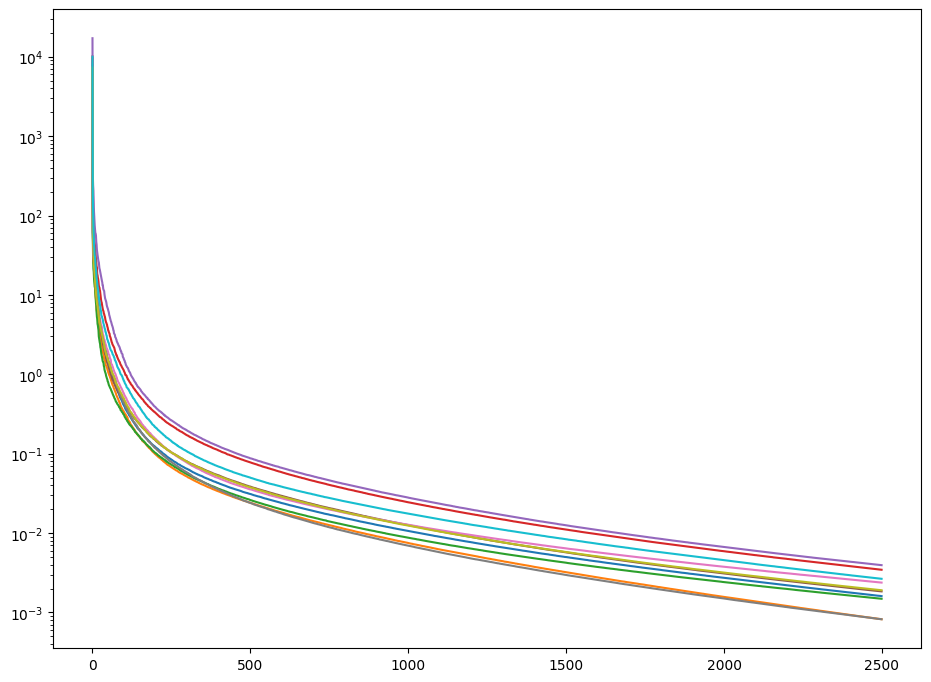

In [28]:
from tqdm import tqdm

fig, axs = plt.subplots()
plt.yscale('log')

chosen_coor = 0 # the coordinate for the logit to compute the NTK over

# On each interation load the parameters from the relevant checkpoint, load a new
# batch and compute the corresponding NTK
for i in tqdm(range(num_runs)):
    # Get a new batch
    data, targets = next(iter(per_grad_train_loader))
    
    # Order the batch by class
    data, targets, indices_ranges = ntk_utils.order_batch(data, targets, 10)
    y = [1 if c == chosen_coor else -1 for c in targets]
    y = np.expand_dims(np.array(y), axis=1)
    
    # Compute the gradients for the relevant checkpoint
    checkpoint_file = '{}/init{}.p'.format(checkpoint_dir, i)
    fw = ntk_utils.f_nabla_w(checkpoint_file, input_data=data)
    
    # Select the gradients for the specific coordinate
    fw_coor = fw[:,:,chosen_coor]
    
    # Compute the NTK for the chosen coordinate
    coor_NTK = ntk_utils.NTK(fw, coor=chosen_coor)
    value = y.transpose() @ coor_NTK @ y
    value /= np.linalg.norm(y) ** 2 * np.linalg.norm(coor_NTK)
    print(value.item())
    
    # Compute eigenvalues for the NTK
    eigs = np.linalg.eigvalsh(coor_NTK)
    eigs_reversed_sorted = np.sort(eigs)[::-1]
    max_eig = eigs_reversed_sorted[0]
    
    # Add the normalized spectrum to the plot
    axs.plot(eigs_reversed_sorted[:batch_size//2])


fig.set_size_inches(11.2, 8.3)
fig.savefig('lenet5mnist.png')